# TensorFlow Regression Example

## Creating Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)

In [3]:
x_data[[1,2,3]]

array([  1.00000100e-05,   2.00000200e-05,   3.00000300e-05])

In [4]:
noise = np.random.randn(len(x_data))

In [5]:
# y = mx + b + noise_levels
b = 5

y_true =  (0.5 * x_data ) + 5 + noise

In [6]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [7]:
my_data.head()

,X Data,Y
0,0.00000,7.359862
1,0.00001,5.942897
2,0.00002,5.669196
3,0.00003,5.601758
4,0.00004,5.864825


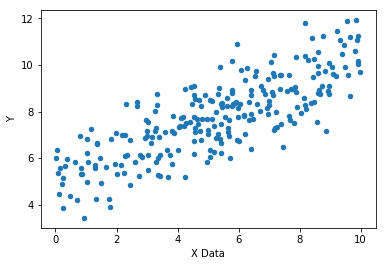

In [8]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [9]:
import tensorflow as tf

In [10]:
print(tf.__version__)

1.3.0


In [11]:
# Random 10 points to grab
batch_size = 8

** Variables **

In [12]:
m = tf.Variable(0.5)
b = tf.Variable(1.0)

** Placeholders **

In [13]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

** Graph **

In [14]:
y_model = m*xph + b

** Loss Function **

In [15]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer **

In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [17]:
init = tf.global_variables_initializer()

### Session

In [18]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 1000
    
    for i in range(batches):
        #print(len(x_data))
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        #print(len(rand_ind))
        #print(rand_ind)
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

In [19]:
model_m

0.49051669

In [20]:
model_b

4.8960199

### Results

In [21]:
y_hat = x_data * model_m + model_b

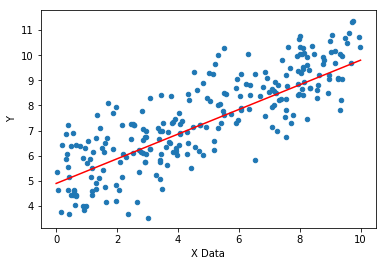

In [22]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [23]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [25]:
feat_cols

[_NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [26]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/wc/97m43k5n4knd4vkdthrfb27r0000gn/T/tmphk9hz306', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [29]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [30]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [31]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [32]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator

In [33]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/wc/97m43k5n4knd4vkdthrfb27r0000gn/T/tmphk9hz306/model.ckpt.
INFO:tensorflow:loss = 263.209, step = 1
INFO:tensorflow:global_step/sec: 1101.19
INFO:tensorflow:loss = 8.7412, step = 101 (0.091 sec)
INFO:tensorflow:global_step/sec: 1059.44
INFO:tensorflow:loss = 13.9013, step = 201 (0.094 sec)
INFO:tensorflow:global_step/sec: 1010.37
INFO:tensorflow:loss = 6.94745, step = 301 (0.099 sec)
INFO:tensorflow:global_step/sec: 1009.45
INFO:tensorflow:loss = 0.79814, step = 401 (0.099 sec)
INFO:tensorflow:global_step/sec: 790.951
INFO:tensorflow:loss = 6.41671, step = 501 (0.127 sec)
INFO:tensorflow:global_step/sec: 867.108
INFO:tensorflow:loss = 7.43757, step = 601 (0.115 sec)
INFO:tensorflow:global_step/sec: 832.368
INFO:tensorflow:loss = 3.86429, step = 701 (0.120 sec)
INFO:tensorflow:global_step/sec: 875.672
INFO:tensorflow:loss = 0.483311, step = 801 (0.114 sec)
INFO:tensorflow:global_step/

### Evaluation

In [34]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2017-09-28-23:09:38
INFO:tensorflow:Restoring parameters from /var/folders/wc/97m43k5n4knd4vkdthrfb27r0000gn/T/tmphk9hz306/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:E

INFO:tensorflow:Evaluation [215/1000]
INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [430/1000]
INFO:tensorflow:Evaluation [431/1000]
INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [646/1000]
INFO:tensorflow:Evaluation [647/1000]
INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [862/1000]
INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorf

In [35]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2017-09-28-23:09:50
INFO:tensorflow:Restoring parameters from /var/folders/wc/97m43k5n4knd4vkdthrfb27r0000gn/T/tmphk9hz306/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:E

INFO:tensorflow:Evaluation [215/1000]
INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [430/1000]
INFO:tensorflow:Evaluation [431/1000]
INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [645/1000]
INFO:tensorflow:Evaluation [646/1000]
INFO:tensorflow:Evaluation [647/1000]
INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [861/1000]
INFO:tensorflow:Evaluation [862/1000]
INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorf

In [36]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.0894802, 'loss': 4.3579206, 'global_step': 1000}
eval metrics: {'average_loss': 1.1264945, 'loss': 4.5059781, 'global_step': 1000}


### Predictions

In [37]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [38]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Restoring parameters from /var/folders/wc/97m43k5n4knd4vkdthrfb27r0000gn/T/tmphk9hz306/model.ckpt-1000


[{'predictions': array([ 4.26018047], dtype=float32)},
 {'predictions': array([ 4.92819738], dtype=float32)},
 {'predictions': array([ 5.59621429], dtype=float32)},
 {'predictions': array([ 6.26423073], dtype=float32)},
 {'predictions': array([ 6.93224812], dtype=float32)},
 {'predictions': array([ 7.60026455], dtype=float32)},
 {'predictions': array([ 8.26828194], dtype=float32)},
 {'predictions': array([ 8.93629837], dtype=float32)},
 {'predictions': array([ 9.60431576], dtype=float32)},
 {'predictions': array([ 10.27233219], dtype=float32)}]

In [39]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Restoring parameters from /var/folders/wc/97m43k5n4knd4vkdthrfb27r0000gn/T/tmphk9hz306/model.ckpt-1000


In [40]:
predictions

[array([ 4.26018047], dtype=float32),
 array([ 4.92819738], dtype=float32),
 array([ 5.59621429], dtype=float32),
 array([ 6.26423073], dtype=float32),
 array([ 6.93224812], dtype=float32),
 array([ 7.60026455], dtype=float32),
 array([ 8.26828194], dtype=float32),
 array([ 8.93629837], dtype=float32),
 array([ 9.60431576], dtype=float32),
 array([ 10.27233219], dtype=float32)]

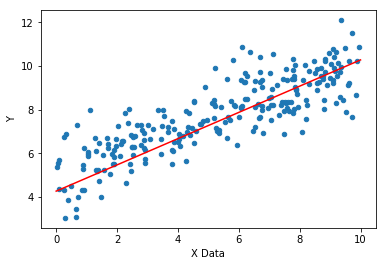

In [41]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')

# Great Job!